In [1]:
import pandas as pd
import xgboost 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from pathlib import Path
import shap
from fastai.tabular.all import *

pd.options.display.max_columns = 70
pd.options.mode.chained_assignment = None

`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead


In [2]:
path = Path('C:/Users/Arpan/Downloads/Education/Project/Rossmann Sales Prediction')

In [3]:
trainval = pd.read_csv(path/'trainval.csv', low_memory=False, parse_dates=[1])
test = pd.read_csv(path/'test_submission.csv', low_memory=False, parse_dates=[3])

In [4]:
def get_splits(df):
    num_days = 6*7
    stores = df['Store'].unique()
    valid_idx = []
    for store in stores:        
        valid_selection = df[df.Store == store].sort_values('Date')[-num_days:]
        valid_idx.extend(list(valid_selection.index))
    train_idx = list(set(df.index) - set(valid_idx))
    return (train_idx, valid_idx)

In [5]:
splits = get_splits(trainval)
len(splits[0]), len(splits[1])

(797508, 46830)

In [6]:
train, valid = trainval.drop(['LogSales', 'Date'], axis = 1).iloc[splits[0], :], trainval.drop(['LogSales', 'Date'], axis = 1).iloc[splits[1], :]
train.shape, valid.shape

((797508, 30), (46830, 30))

In [7]:
# metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
def mape(y, yhat):
    return np.abs(np.mean((y-yhat)/y))

In [8]:
# get predictions
def get_preds(m, xs, features, exp = False, test = False):
    x = xs[features].copy()
    if test:
        ids = x['Id']
        x = xs.drop('Id', axis = 1)
    preds = m.predict(x)
    if exp:
        preds = np.exp(preds)
    if test:
        p = pd.DataFrame(data = {'Id':ids, 'Sales':preds}).sort_values('Id').reset_index(drop = True)
    else:
        x['Sales'] = xs.Sales
        x['Sales_Pred'] = preds
        p = x
        
    return p

In [9]:
# loading model
xgb_model = (path/'xgb-val.pkl').load()
features_xgb = (path/'feature-xgb.pkl').load()

rf_model = (path/'rf-val.pkl').load()
features_rf = (path/'features-rf.pkl').load()

<b> Tree Based Predictions

In [11]:
valid_preds_xgb = get_preds(xgb_model, valid, features_xgb, exp = True)
categories = [c for c in valid_preds_xgb.columns if valid_preds_xgb[c].dtypes!=np.float64]
valid_preds_xgb[categories] = valid_preds_xgb[categories].astype(np.int64)
valid_preds_rf = get_preds(rf_model, valid, features_rf, exp = True)

<b> Neural Network

In [12]:
# cont cat splits
d = ['Sales', 'Date']
cont, cat = cont_cat_split(trainval.drop(d, axis = 1), dep_var = 'LogSales', max_card = 9000)
# convert to Tabular Pandas
procs = [Categorify, Normalize]
to = TabularPandas(trainval.drop(d, axis = 1), y_names = 'LogSales', cont_names=cont, cat_names = cat, procs = procs, splits=splits)

In [13]:
def nn_rmspe_exp(preds,targs):return rmspe(np.exp(targs.cpu().detach().numpy()), np.exp(preds.cpu().detach().numpy()))
def get_learner(to, bs, layers = [500, 250], **kwargs):    
    dls = to.dataloaders(bs)
    return  tabular_learner(dls, layers = layers, 
                            loss_func = F.mse_loss, 
                            metrics = [nn_rmspe_exp], n_out = 1,
                            y_range = (3., 11.))
learn = get_learner(to, 1024, layers = [600, 300])
learn.load('nn-600-300-wd06')

In [14]:
valid_preds_nn = valid.copy()
valid_preds_nn['Sales_Pred'] = np.exp(learn.get_preds()[0].numpy().flatten().tolist())

In [15]:
print('Validation Metrics XGB')
print('RMSPE: ', rmspe(valid_preds_xgb.Sales, valid_preds_xgb.Sales_Pred))
print('MAPE: ', mape(valid_preds_xgb.Sales, valid_preds_xgb.Sales_Pred))

print('\nValidation Metrics RF')
print('RMSPE: ', rmspe(valid_preds_rf.Sales, valid_preds_rf.Sales_Pred))
print('MAPE: ', mape(valid_preds_rf.Sales, valid_preds_rf.Sales_Pred))

print('\nValidation Metrics Neural Network')
print('RMSPE: ', rmspe(valid_preds_nn.Sales, valid_preds_nn.Sales_Pred))
print('MAPE: ', mape(valid_preds_nn.Sales, valid_preds_nn.Sales_Pred))

Validation Metrics XGB
RMSPE:  0.12841110599088795
MAPE:  0.022565549761478322

Validation Metrics RF
RMSPE:  0.13700288953401557
MAPE:  0.017953907578035593

Validation Metrics Neural Network
RMSPE:  0.11583123787229525
MAPE:  0.004506502285493359


In [119]:
results = {'RMSPE': [], 'MAPE': []}
index = ['Random Forest', 'XGBoost', 'Neural Network (with EE)']

for i in [valid_preds_rf, valid_preds_xgb, valid_preds_nn]:
    results['RMSPE'].append(round(rmspe(i.Sales, i.Sales_Pred),4))
    results['MAPE'].append(round(rmspe(i.Sales, i.Sales_Pred),4))
    
result_df = pd.DataFrame(results, index = index)
result_df

,RMSPE,MAPE
Random Forest,0.1370,0.1370
XGBoost,0.1284,0.1284
Neural Network (with EE),0.1158,0.1158


In [16]:
# visualizing forecast
def plot_forecast(store, df, modelname, **kwargs):
    df.index = trainval.iloc[splits[1]].Date
    sdf = df[df.Store==store]
    sdf[['Sales', 'Sales_Pred']].plot(figsize = (10, 8), title = f'{modelname} Prediction Store {store}')
    plt.legend()
    return plt

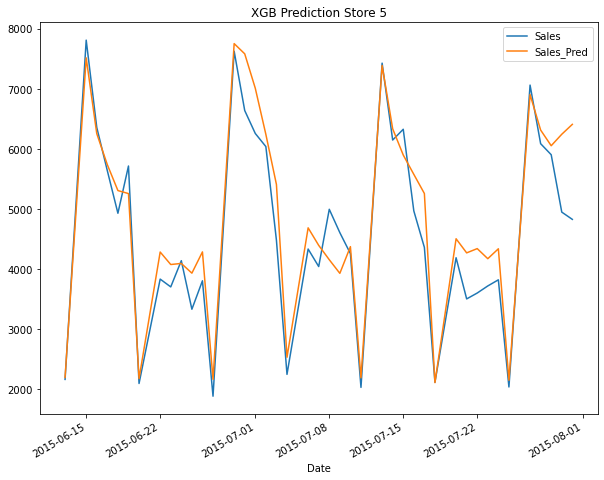

In [17]:
plot_forecast(5, valid_preds_xgb, 'XGB')
plt.show()

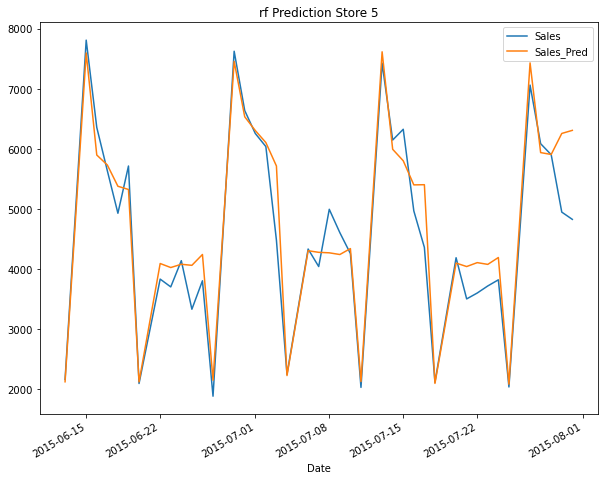

In [18]:
plot_forecast(5, valid_preds_rf, 'rf')
plt.show()

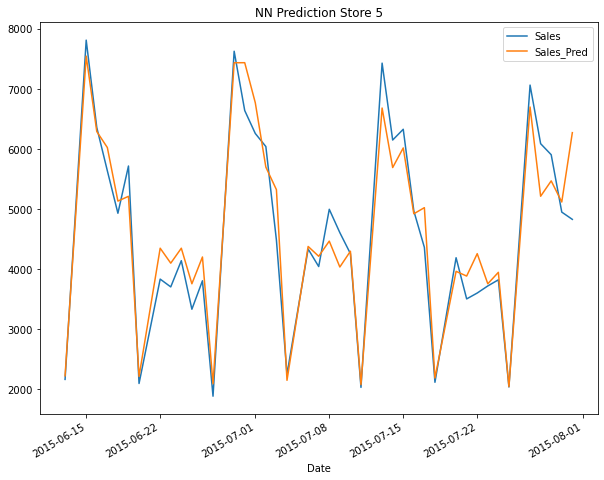

In [19]:
plot_forecast(5, valid_preds_nn, 'NN')
plt.show()

<b> Interpretation

<B> Random Forest

In [33]:
explainerModel = shap.TreeExplainer(rf_model)
shp_values = explainerModel.shap_values(valid_preds_rf.iloc[0])

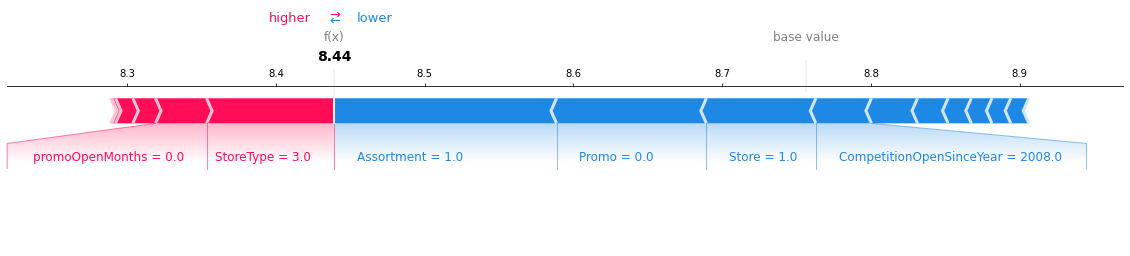

In [34]:
shap.initjs()
shap.force_plot(explainerModel.expected_value, shp_values, valid_preds_rf.iloc[0], matplotlib=True)

<b> XGBoost

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


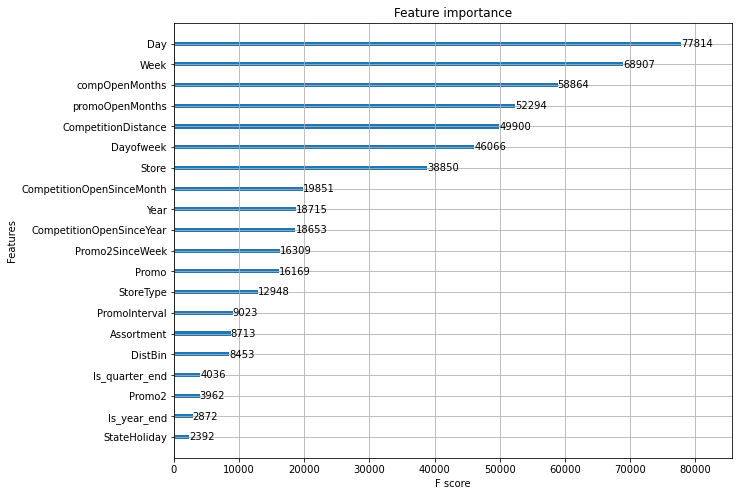

In [146]:
# feature importance
f,ax = plt.subplots(1,1, figsize = (10,8))
xgboost.plot_importance(xgb_model, ax = ax)
f.show()

In [35]:
explainerModel = shap.TreeExplainer(xgb_model)
shp_values = explainerModel.shap_values(valid_preds_xgb[features_xgb].iloc[0])

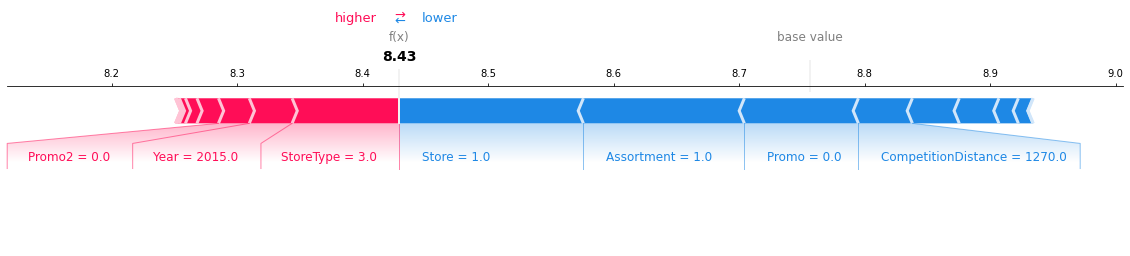

In [37]:
shap.initjs()
shap.force_plot(explainerModel.expected_value, shp_values, valid_preds_xgb[features_xgb].iloc[0], matplotlib=True)

<b> Predictor Function

In [69]:
# will be using xgboost
model = (path/'xgb-full.pkl').load()

In [75]:
train = pd.read_csv(path/'train.csv', low_memory=False, parse_dates=[1])
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [120]:
features_xgb

['Promo',
 'CompetitionDistance',
 'Store',
 'StoreType',
 'Assortment',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'PromoInterval',
 'DistBin',
 'Dayofweek',
 'Promo2SinceWeek',
 'Is_year_end',
 'StateHoliday',
 'compOpenMonths',
 'Week',
 'Day',
 'promoOpenMonths',
 'Is_quarter_end',
 'Year']

In [106]:
def predict(model, inp):
    p = model.predict(inp).item()
    print('Predicted Sales (in $): ', np.exp(p))    
    return p

def get_force(model, inp):
    explainerModel = shap.TreeExplainer(model)
    shp_values = explainerModel.shap_values(inp)
    
    fp = shap.force_plot(explainerModel.expected_value, shp_values, valid_preds_xgb[features_xgb].iloc[0], matplotlib=True)
    return fp

In [101]:
test = test[features_xgb]
test[categories] = test[categories].astype(np.int64)

Predicted Sales (in $):  4112.878524327035


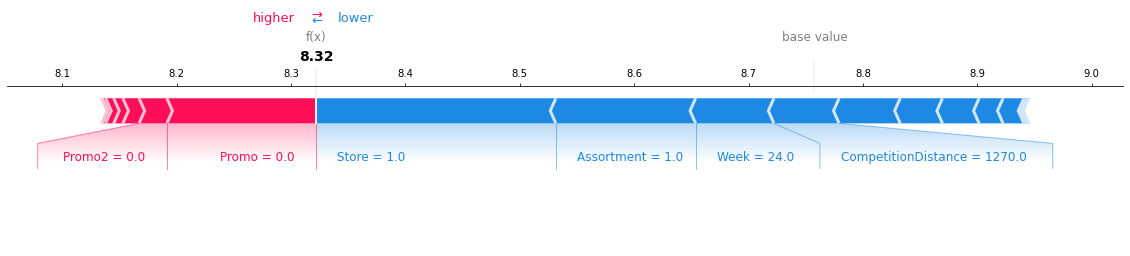

In [136]:
inp = test.iloc[[0]]
p = predict(model, inp)
get_force(model, inp)